In [1]:
import win32com.client
from datetime import date
import numpy as np
import time
from os import listdir
from os.path import isfile, join
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import visa # provides generic usb interface to the powermeter
from ThorlabsPM100 import ThorlabsPM100 # actually knows how to talk to the powermeter
%matplotlib notebook

## set basic parameters below

In [2]:
### set folder here

# construct Packer-xkcd-compliant datestring
datestring = date.today().isoformat()

folder = r"F:\Data\jrowland\{}\PowerMeasurements".format(datestring)

if not os.path.exists(folder):
    os.makedirs(folder)
    
folder

'F:\\Data\\jrowland\\2018-10-30\\PowerMeasurements'

In [3]:
class DigitalPowerMeasurer:
    """
    This class takes analog devices on an AI card, a usb connection to the power meters, 
    a PrairieLink, and xmls and gpls to definethe SLM experiment.
    It then fires the experiment once to find the best power range, 
    initializes the analog devices, starts the SLM experiments and listens to the analog inputs.
    returns a power range array and the analog input array."""
    
    def __init__(self,prairie_link, visa_resource_manager, power_meter_list):
        
        # store configruation
        self.pl = prairie_link
        self.rm = visa_resource_manager
        self.num_power_meters = len(power_meter_list)
        
        # create power_meters
        self.instruments = []
        self.power_meters = []
        for i in range(self.num_power_meters):
            self.instruments.append(rm.open_resource(power_meter_list[i]))
            self.power_meters.append(ThorlabsPM100(inst=self.instruments[i]))
        
    def measure(self,laser_name,wavelength,laser_power,window_length=5):
        """
        laser name needs to match a laser name in PrairieView
        Wavelength needs to be accessible trhough the PrairieView 2P laser tab
        take {laser_name:laser_power[PV]} dictionary and perform measurement with this power for 3s"""
        
        voltage_array = np.zeros(self.num_power_meters)
        
        pl.SendScriptCommands('-SetLaserPower ' + laser_name + ' ' + str(laser_power))
        time.sleep(window_length)
        
        for i in range(self.num_power_meters):
            # set the power meter wavelength
            self.power_meters[i].sense.correction.wavelength = wavelength
            
            # use USB correction to measure current power
            voltage_array[i] = self.power_meters[i].read
        
        pl.SendScriptCommands('-SetLaserPower ' + laser_name + ' ' + str(0))
        
        return voltage_array

In [4]:
def pockel_curve(x,I,k,phi):
    return I * np.cos(k*x + phi)**2

def arctangent(x, phi, I_0, I, k):
    return I * np.arctan(k*(x + phi)) + I_0

In [5]:
# Start PrairieLink
pl = win32com.client.Dispatch('PrairieLink.Application')
print('object created')

# Connect to Client
pl.Connect()
print(pl.Connected)

object created
<bound method Connected of <COMObject PrairieLink.Application>>


In [46]:
# Search for PowerMeters
rm=visa.ResourceManager()
resource_list = rm.list_resources()
print(resource_list)

# create powermeter, assume that it is the first object showing up in the above list
pm100 = DigitalPowerMeasurer(pl,rm,[resource_list[0]])

('USB0::0x1313::0x8079::P1003857::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR', 'ASRL5::INSTR', 'ASRL6::INSTR', 'ASRL7::INSTR', 'ASRL8::INSTR', 'ASRL10::INSTR', 'ASRL13::INSTR')


# MAKE sure you:
## open laser shutters
## center galvos
## check if you are in resonant galvo mode
## check PMT shutters are closed
## think about SLM if using uncaging

In [65]:
laser_name = 'Imaging'
wavelength = 765

#pl.SendScriptCommands('-SetMultiPhotonWavelength' + ' ' + str(wavelength) + ' ' + str(1))
# Allow Chameleon to change its colours
#time.sleep(15)

powerspace = np.arange(0,1100,100)

len_powerspace = len(powerspace)

voltage_array = np.zeros(len_powerspace)

for i in range(len_powerspace):
    voltage_array[i] = pm100.measure('Imaging', wavelength, powerspace[i],6)
    time.sleep(6)
    print(voltage_array[i])

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pyvisa\resources\messagebased.py:573: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


0.00531332847
0.044425115
0.111874714
0.195559368
0.271716803
0.324554741
0.350826114
0.34300372
0.308024406
0.243379161
0.17578198


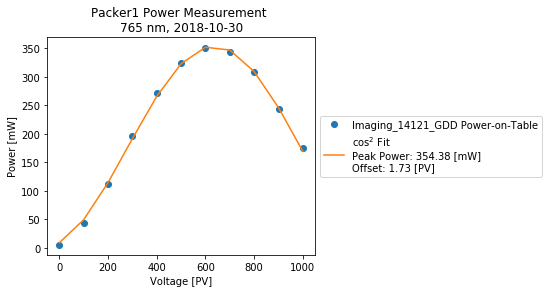

In [66]:
laser_name = 'Imaging_14121_GDD'

guess = (0.14,1/500,1)
popt, pcov = curve_fit(pockel_curve,powerspace,voltage_array,guess)

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(powerspace,1000*voltage_array,linestyle='None',marker='o',label=laser_name + ' Power-on-Table')
ax.plot(powerspace,1000*pockel_curve(powerspace,*popt),label=r"cos$^{2}$ Fit" + "\n"
         r"Peak Power: {:.2f} [mW]".format(popt[0]*1000) + "\n" +
         "Offset: {:.2f} [PV]".format(popt[2]))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Voltage [PV]")
plt.ylabel("Power [mW]")
plt.title("Packer1 Power Measurement \n" + str(wavelength) + " nm, " + datestring)

# construct Packer-xkcd-compliant datestring
datestring = date.today().isoformat()
operator = "mloidolt"


os.chdir(folder)
plt.savefig(datestring+'_'+laser_name+'_'+str(wavelength)+".pdf",bbox_extra_artists=(legend,), bbox_inches='tight')
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'powerspace',powerspace)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'voltage_array',voltage_array)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'popt',popt)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'pcov',pcov)

## no longer have 2p laser tab, so change laser wavelength manually
#### the power meter wavelength is set automatically

In [16]:
laser_name = 'Imaging'
wavelength = 765

#pl.SendScriptCommands('-SetMultiPhotonWavelength' + ' ' + str(wavelength) + ' ' + str(1))
# Allow Chameleon to change its colours
#time.sleep(15)

powerspace = np.arange(0,1100,100)

len_powerspace = len(powerspace)

voltage_array = np.zeros(len_powerspace)

for i in range(len_powerspace):
    voltage_array[i] = pm100.measure('Imaging', wavelength, powerspace[i],5)
    print(voltage_array[i])
    time.sleep(3)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pyvisa\resources\messagebased.py:573: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


0.0011807495
0.00103307841
0.00900307111
0.024500221
0.0504764467
0.0786665007
0.115564458
0.151724502
0.188179716
0.220354766
0.255481631
0.277915716
0.304924995
0.321898073
0.331639141
0.331639141
0.327949315
0.316732317
0.298726082
0.277177691
0.257105231


In [15]:
pm100.measure('Imaging', wavelength, 600,6)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pyvisa\resources\messagebased.py:573: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


array([0.2993165])

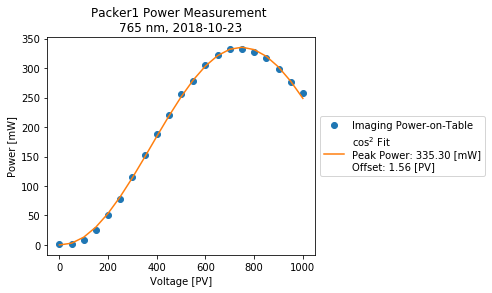

In [20]:
powerspace = np.arange(0,1050,50)

guess = (0.14,1/500,1)
popt, pcov = curve_fit(pockel_curve,powerspace,voltage_array,guess)

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(powerspace,1000*voltage_array,linestyle='None',marker='o',label=laser_name + ' Power-on-Table')
ax.plot(powerspace,1000*pockel_curve(powerspace,*popt),label=r"cos$^{2}$ Fit" + "\n"
         r"Peak Power: {:.2f} [mW]".format(popt[0]*1000) + "\n" +
         "Offset: {:.2f} [PV]".format(popt[2]))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])


#operator = "mloidolt"

# Put a legend to the right of the current axis
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Voltage [PV]")
plt.ylabel("Power [mW]")
plt.title("Packer1 Power Measurement \n" + str(wavelength) + " nm, " + datestring)



os.chdir(folder)
plt.savefig(datestring+'_'+laser_name+'_'+str(wavelength)+".pdf",bbox_extra_artists=(legend,), bbox_inches='tight')
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'powerspace',powerspace)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'voltage_array',voltage_array)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'popt',popt)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'pcov',pcov)

# be very careful not to go above 800 PV if using uncaging path 
# Pmax = 5W for the thermosensor
# be even MORE careful if using the wand Pmax = 0.5W

# use 2x SLM single spot deflections at max step size

In [53]:
## set the uncaging path to measure here

#uc_path = 'uncaging_no_slm'
uc_path = 'uncaging_slm_single_spot' 


In [54]:
uc_path

'uncaging_slm_single_spot'

In [55]:
# dont try hack this to make it faster, it causes errors

laser_name = 'Uncaging'
wavelength=1030

if uc_path == 'uncaging_no_slm':
    powerspace = np.arange(200,750,50)
elif uc_path == 'uncaging_slm_single_spot':
    powerspace = np.arange(200,1100,100)
else:
    raise('invalid uncaging path')


len_powerspace = len(powerspace)

voltage_array = np.zeros(len_powerspace)

for i in range(len_powerspace):
    print(powerspace[i])
    voltage_array[i] = pm100.measure(laser_name, wavelength, powerspace[i],window_length=7)
    print(voltage_array[i])
    time.sleep(10)
    
assert max(voltage_array) < 10, 'if power meter is not allowed to reset long enough between measurements, an error can be raised here'

200


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pyvisa\resources\messagebased.py:573: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


-0.00136019418
300
0.00785882864
400
0.0513849519
500
0.133147448
600
0.267201632
700
0.417578161
800
0.547703087
900
0.66830653
1000
0.703066885


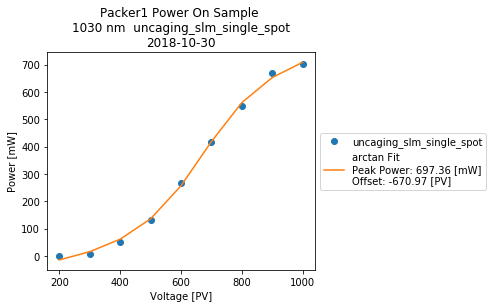

In [56]:
datestring = date.today().isoformat()
guess = (-700,500,300,0.02)
popt, pcov = curve_fit(arctangent,powerspace,voltage_array,guess)

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(powerspace,1000*voltage_array,linestyle='None',marker='o',label=uc_path)
ax.plot(powerspace,1000*arctangent(powerspace,*popt),label=r"arctan Fit" + "\n"
         r"Peak Power: {:.2f} [mW]".format((popt[2]+popt[1])*1000) + "\n" +
         "Offset: {:.2f} [PV]".format(popt[0]))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Voltage [PV]")
plt.ylabel("Power [mW]")
plt.title("Packer1 Power On Sample \n" + str(wavelength) + " nm " + ' ' + uc_path + "\n" + datestring)

# construct Packer-xkcd-compliant datestring
datestring = date.today().isoformat()
operator = "mloidolt"

os.chdir(folder)
plt.savefig(datestring+'_'+uc_path+'_'+str(wavelength)+".pdf",bbox_extra_artists=(legend,), bbox_inches='tight')
np.save(datestring+'_'+uc_path+'_'+str(wavelength)+'_'+'powerspace',powerspace)
np.save(datestring+'_'+uc_path+'_'+str(wavelength)+'_'+'voltage_array',voltage_array)
np.save(datestring+'_'+uc_path+'_'+str(wavelength)+'_'+'popt',popt)
np.save(datestring+'_'+uc_path+'_'+str(wavelength)+'_'+'pcov',pcov)

In [10]:
PV = np.arange(300,700,50)
print(PV)
I = np.asarray([0.04,0.124,0.277,0.494,0.772,1.117,1.532,1.911])
Y = I/2 * 680
print(Y)

[300 350 400 450 500 550 600 650]
[ 13.6   42.16  94.18 167.96 262.48 379.78 520.88 649.74]


[-5.82438089e+02  4.71591407e+02  4.31698122e+02  6.47443366e-03]
[-7.e+02  5.e+02  3.e+02  2.e-02]


<IPython.core.display.Javascript object>


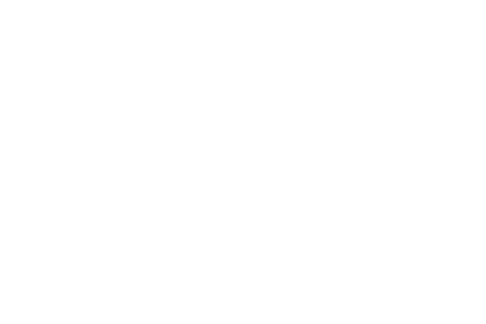

Text(0.5,1,'Packer1 Power Measurement \n1030 nm, 2018-09-07')

<IPython.core.display.Javascript object>


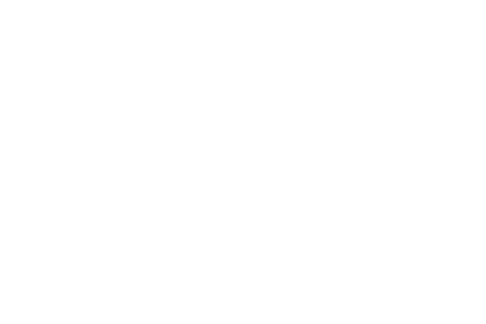

In [9]:
folder = r"F:\Data\mloidolt\2018-09-05\2018-09-05_PowerMeasurements"
os.chdir(folder)

datestring = date.today().isoformat()

laser_name = 'Uncaging'
wavelength=1030

powerspace = np.load("2018-09-05_Uncaging_1030_powerspace.npy")
voltage_array = np.load("2018-09-05_Uncaging_1030_voltage_array.npy")
stable_popt = np.load("2018-09-05_Uncaging_1030_popt.npy")

Y = I/2 * 680
X = PV

old_popt = np.load(r"F:\Data\mloidolt\2018-08-23\2018-08-23_PowerMeasurements\2018-08-23_Uncaging_1030_popt.npy")
powerspace = np.arange(300,1000,30)

guess = (-700,500,300,0.02)

popt, pcov = curve_fit(arctangent,X,Y,guess)
print(popt)
print(old_popt)

fig = plt.figure()
ax = plt.subplot(111)

#plt.plot(powerspace,arctangent(powerspace,*old_popt)/multiplicator)
ax.plot(X,Y,linestyle='None',marker='o',color='blue',label=laser_name + ' Peak Power')
ax.plot(powerspace,arctangent(powerspace,*popt),color='blue',label=r"arctan Fit" + "\n"
         r"Peak Power: {:.2f} [mW]".format((popt[2]+popt[1])*1000) + "\n" +
         "Offset: {:.2f} [PV]".format(popt[0]))
ax.plot(powerspace,1000*voltage_array,linestyle='None',marker='o',label=laser_name + ' Power afer 5s',color='green')
ax.plot(powerspace,1000*arctangent(powerspace,*stable_popt),label=r"arctan Fit" + "\n"
         r"Peak Power: {:.2f} [mW]".format((popt[2]+popt[1])*1000) + "\n" +
         "Offset: {:.2f} [PV]".format(old_popt[0]),color='green')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Voltage [PV]")
plt.ylabel("Power [mW]")
plt.title("Packer1 Power Measurement \n" + str(wavelength) + " nm, " + datestring)